In [17]:
import pandas as pd

# Read file manually, skipping the header metadata
df = pd.read_csv("GSE28379_series_matrix.txt", sep="\t", comment="!", index_col=0)
df.head()

,GSM701542,GSM701543,GSM701544,GSM701545
ID_REF,,,,
1007_s_at,615.52540,739.778000,720.900400,735.847500
1053_at,319.87120,654.391660,730.687200,515.430500
117_at,20.04304,32.151443,14.417517,24.944078
121_at,239.84415,171.029600,137.311610,176.759780
1255_g_at,155.14342,335.751860,177.997860,128.042790


In [18]:
# Renaming the columns to specify the control and the disease patients
df = df.rename(columns={'GSM701542': 'control1', 'GSM701543': 'control2', 'GSM701544': 'alzheimer1', 'GSM701545': 'alzheimer2'})
df.head()

,control1,control2,alzheimer1,alzheimer2
ID_REF,,,,
1007_s_at,615.52540,739.778000,720.900400,735.847500
1053_at,319.87120,654.391660,730.687200,515.430500
117_at,20.04304,32.151443,14.417517,24.944078
121_at,239.84415,171.029600,137.311610,176.759780
1255_g_at,155.14342,335.751860,177.997860,128.042790


In [19]:
df.describe()

,control1,control2,alzheimer1,alzheimer2
count,54675.000000,54675.000000,54675.000000,54675.000000
mean,311.163554,324.680869,293.984405,234.041640
std,973.062209,1026.411176,951.423063,854.320162
min,0.098684,0.040403,0.053092,0.036289
25%,10.888680,9.469739,7.973378,6.638893
50%,38.069134,35.693405,29.521608,24.667880
75%,179.445000,179.470150,155.781465,115.830295
max,13434.690000,13528.281000,13031.392000,13826.742000


In [20]:
df.isnull().any().any()

np.False_

In [21]:
import numpy as np

# df = (df - df.min()) / (df.max() - df.min())
df_log = np.log2(df + 1)
df_log.describe()

,control1,control2,alzheimer1,alzheimer2
count,54675.000000,54675.000000,54675.000000,54675.000000
mean,5.570519,5.504588,5.297840,5.021360
std,2.762567,2.842117,2.842290,2.721586
min,0.135777,0.057143,0.074632,0.051426
25%,3.571517,3.388154,3.165651,2.933364
50%,5.287957,5.197449,4.931759,4.681892
75%,7.495415,7.495616,7.292611,6.868271
max,13.713783,13.723798,13.669814,13.755278


<Axes: >

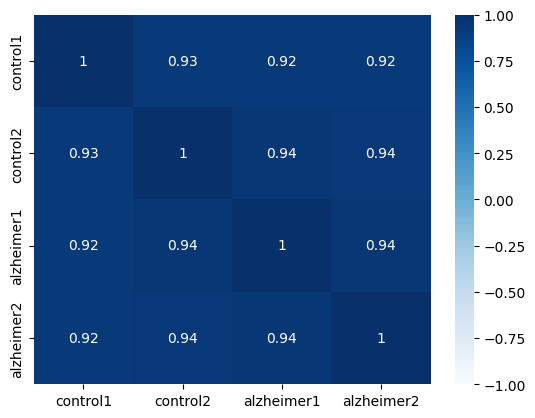

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(df_log.corr(numeric_only=True), cmap='Blues', annot=True, vmin=-1, vmax=1)

In [23]:
# sns.clustermap(df_log, cmap="viridis", figsize=(6, 4), col_cluster=True)
# plt.show()

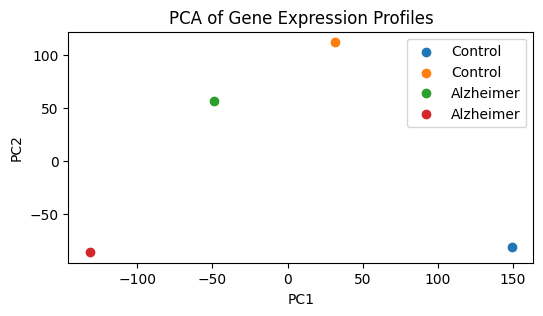

In [24]:
from sklearn.decomposition import PCA

sample_labels = {
    "control1": "Control",
    "control2": "Control",
    "alzheimer1": "Alzheimer",
    "alzheimer2": "Alzheimer"
}

pca = PCA(n_components=2)
pca_result = pca.fit_transform(df_log.T)

plt.figure(figsize=(6,3))
for i, sample in enumerate(df_log.columns):
    label = sample_labels[sample]
    plt.scatter(pca_result[i,0], pca_result[i,1], label=label)
plt.legend()
plt.title("PCA of Gene Expression Profiles")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

<Figure size 1000x800 with 0 Axes>

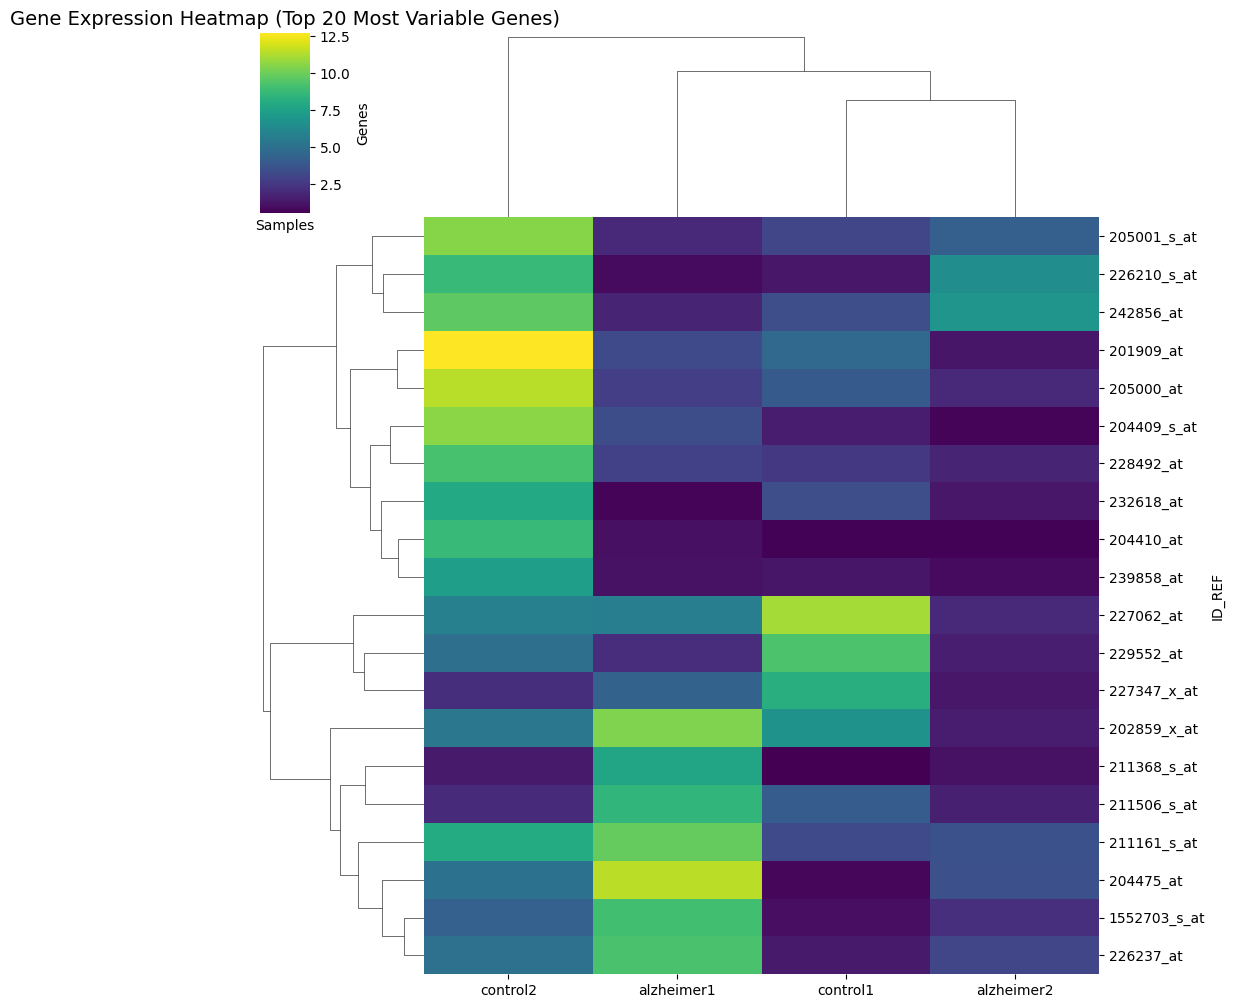

In [25]:
# select a smaller subset of genes
# We'll take the top 50 most variable genes for clarity.
df_subset = df_log.loc[df_log.var(axis=1).nlargest(20).index]

# Create the heatmap
plt.figure(figsize=(10, 8))
sns.clustermap(
    df_subset,               # gene expression data
    cmap="viridis",          # color scheme (dark blue = low, yellow = high)
    xticklabels=True,        # show sample names (columns)
    yticklabels=True        # hide gene names (too many to read; can change to True if few)
)

# Add title and labels
plt.title("Gene Expression Heatmap (Top 20 Most Variable Genes)", fontsize=14)
plt.xlabel("Samples")
plt.ylabel("Genes")
plt.show()


In [26]:
df_log['mean_control'] = df_log[['control1', 'control2']].mean(axis=1)
df_log['mean_alzheimer'] = df_log[['alzheimer1', 'alzheimer2']].mean(axis=1)

# Calculate the fold change
df_log['fold_change'] = df_log['mean_alzheimer'] / df_log['mean_control']

# Convert it to log2 scale
df_log['log2FC'] = df_log['mean_alzheimer'] - df_log['mean_control']

# Step 4: Show the top few rows
results = df_log[['mean_control', 'mean_alzheimer', 'fold_change', 'log2FC']]
results.head()

,mean_control,mean_alzheimer,fold_change,log2FC
ID_REF,,,,
1007_s_at,9.400457,9.510439,1.011700,0.109982
1053_at,8.841032,9.263757,1.047814,0.422725
117_at,4.723135,4.321916,0.915052,-0.401220
121_at,7.669235,7.292782,0.950914,-0.376453
1255_g_at,7.841135,7.247752,0.924324,-0.593383


In [27]:
from scipy.stats import ttest_ind

results = df_log[['mean_control', 'mean_alzheimer', 'fold_change', 'log2FC']].copy()

# Split the samples into control and alzheimer
control_cols = ['control1', 'control2']
alz_cols = ['alzheimer1', 'alzheimer2']

# Run t_tets for each gene (rows)
p_values = []
for gene in df_log.index:
    control_vals = df_log.loc[gene, control_cols]
    alz_vals = df_log.loc[gene, alz_cols]
    t_stat, p_val = ttest_ind(control_vals, alz_vals, equal_var=False)
    p_values.append(p_val)

results['p_values'] = p_values
results.head()

,mean_control,mean_alzheimer,fold_change,log2FC,p_values
ID_REF,,,,,
1007_s_at,9.400457,9.510439,1.011700,0.109982,0.558016
1053_at,8.841032,9.263757,1.047814,0.422725,0.561539
117_at,4.723135,4.321916,0.915052,-0.401220,0.506644
121_at,7.669235,7.292782,0.950914,-0.376453,0.348317
1255_g_at,7.841135,7.247752,0.924324,-0.593383,0.468156


In [28]:
from statsmodels.stats.multitest import multipletests

pvals = results['p_values']

# Applying benjamini hochberg correction
reject, adj_pvals, _, _ = multipletests(pvals, alpha=0.05, method='fdr_bh')

results['adj_p_values'] = adj_pvals
results['significant'] = reject
results.head()

,mean_control,mean_alzheimer,fold_change,log2FC,p_values,adj_p_values,significant
ID_REF,,,,,,,
1007_s_at,9.400457,9.510439,1.011700,0.109982,0.558016,0.918204,False
1053_at,8.841032,9.263757,1.047814,0.422725,0.561539,0.918541,False
117_at,4.723135,4.321916,0.915052,-0.401220,0.506644,0.916554,False
121_at,7.669235,7.292782,0.950914,-0.376453,0.348317,0.916452,False
1255_g_at,7.841135,7.247752,0.924324,-0.593383,0.468156,0.916452,False


In [29]:
results.describe()

,mean_control,mean_alzheimer,fold_change,log2FC,p_values,adj_p_values
count,54675.000000,54675.000000,54675.000000,54675.000000,54675.000000,54675.000000
mean,5.537554,5.159600,0.949922,-0.377954,0.483106,0.931600
std,2.752333,2.740429,0.294241,0.751688,0.270779,0.024259
min,0.172922,0.175614,0.059413,-6.386534,0.000063,0.916452
25%,3.397465,2.989591,0.846013,-0.775772,0.257394,0.916452
50%,5.205165,4.738917,0.943125,-0.351174,0.460696,0.916452
75%,7.479191,7.065990,1.005287,0.029812,0.706207,0.941509
max,13.712320,13.712546,9.381746,4.825749,0.999992,0.999992


In [30]:
results['significant'].unique()

array([False])

c:\Users\USER\AppData\Local\Programs\Python\Python313\Lib\site-packages\bioinfokit\visuz.py:153: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['color_add_axy'].fillna(color[1], inplace=True)  # intermediate


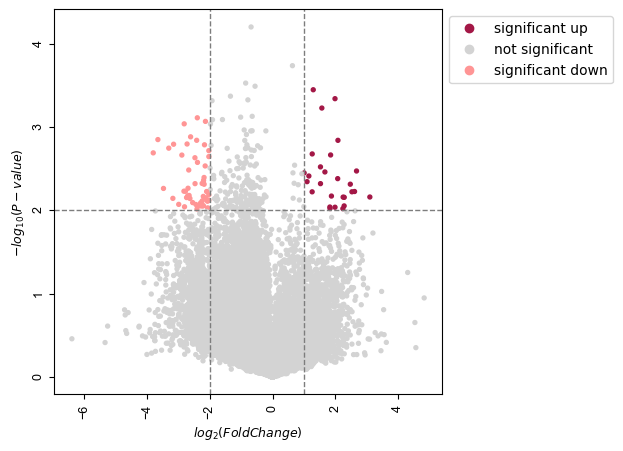

In [31]:
from bioinfokit import visuz, analys

visuz.GeneExpression.volcano(df=results, lfc='log2FC', pv='p_values', lfc_thr=(1, 2), pv_thr=(0.01, 0.01), geneid=results.index, genenames=(list(results.index[:10])),
    color=("#A31746", "lightgrey", "#FF9595"), show=True, plotlegend=True, legendpos='upper right',
    sign_line=True, legendanchor=(1.46,1))

In [32]:
# Filter genes based on log2FC and p-value thresholds
significant_genes = results[
    ((results['log2FC'] >= 1) | (results['log2FC'] <= -1)) &  # up or down
    (results['p_values'] <= 0.01)                             # significant p-value
]

print(f"Number of significant genes: {len(significant_genes)}")

significant_genes['score'] = -np.log10(significant_genes['p_values']) * significant_genes['log2FC'].abs()

top_genes = significant_genes.sort_values('score', ascending=False).head(10)
top_genes

Number of significant genes: 155


C:\Users\USER\AppData\Local\Temp\ipykernel_2380\3141104127.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  significant_genes['score'] = -np.log10(significant_genes['p_values']) * significant_genes['log2FC'].abs()


,mean_control,mean_alzheimer,fold_change,log2FC,p_values,adj_p_values,significant,score
ID_REF,,,,,,,,
229340_at,4.900949,1.251723,0.255404,-3.649227,0.001419,0.916452,False,10.392962
232794_at,4.494170,0.696997,0.155089,-3.797174,0.002049,0.916452,False,10.208756
232195_at,4.861959,1.558835,0.320619,-3.303124,0.001798,0.916452,False,9.067415
239344_at,4.181975,1.032196,0.246820,-3.149779,0.001614,0.916452,False,8.794733
231618_s_at,4.156448,1.344389,0.323447,-2.812059,0.000919,0.916452,False,8.539399
238169_at,4.638035,1.166731,0.251557,-3.471304,0.005471,0.916452,False,7.851880
224380_s_at,4.213987,1.327238,0.314960,-2.886750,0.002177,0.916452,False,7.684738
1563002_at,3.284790,0.564243,0.171774,-2.720547,0.001604,0.916452,False,7.603689
231605_at,5.494436,2.886077,0.525273,-2.608359,0.001315,0.916452,False,7.514725


In [33]:
significant_genes['score'] = -np.log10(significant_genes['p_values']) * significant_genes['log2FC'].abs()

top_genes = significant_genes.sort_values('score', ascending=False).head(10)
top_genes

C:\Users\USER\AppData\Local\Temp\ipykernel_2380\3501440563.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  significant_genes['score'] = -np.log10(significant_genes['p_values']) * significant_genes['log2FC'].abs()


,mean_control,mean_alzheimer,fold_change,log2FC,p_values,adj_p_values,significant,score
ID_REF,,,,,,,,
229340_at,4.900949,1.251723,0.255404,-3.649227,0.001419,0.916452,False,10.392962
232794_at,4.494170,0.696997,0.155089,-3.797174,0.002049,0.916452,False,10.208756
232195_at,4.861959,1.558835,0.320619,-3.303124,0.001798,0.916452,False,9.067415
239344_at,4.181975,1.032196,0.246820,-3.149779,0.001614,0.916452,False,8.794733
231618_s_at,4.156448,1.344389,0.323447,-2.812059,0.000919,0.916452,False,8.539399
238169_at,4.638035,1.166731,0.251557,-3.471304,0.005471,0.916452,False,7.851880
224380_s_at,4.213987,1.327238,0.314960,-2.886750,0.002177,0.916452,False,7.684738
1563002_at,3.284790,0.564243,0.171774,-2.720547,0.001604,0.916452,False,7.603689
231605_at,5.494436,2.886077,0.525273,-2.608359,0.001315,0.916452,False,7.514725


In [34]:
sig_genes = results[(results['significant']) & (abs(results['log2FC']) > 1)]
sig_genes.head()

,mean_control,mean_alzheimer,fold_change,log2FC,p_values,adj_p_values,significant
ID_REF,,,,,,,
